# Loading Packages

In [1]:
from tensorflow import keras

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import numpy as np

import cv2

import torch
import torch.nn.functional as F

# Loading Data and plotting some of its values

In [2]:
(X, y), (X_test, y_test) = keras.datasets.mnist.load_data()
X.shape

(60000, 28, 28)

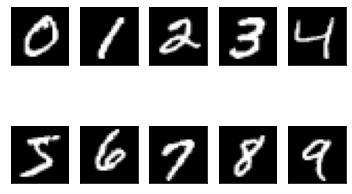

In [3]:
indeces = []
for i in range(0, 10):
    indeces.append(np.where(y == i)[0][0])

gs = GridSpec(2, 5)
for i in range(0, 2):
    for j in range(0, 5):
        ax = plt.subplot(gs[i, j])
        ax.imshow(X[ indeces[i * 5 + j ] ], cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])
plt.show()

# Getting Validation vs Training performance

In [4]:
validation_ratio = 0.1
X_train, y_train, X_validation, y_validation = X[0: int((1-validation_ratio) * len(X))], y[0: int((1-validation_ratio) * len(X))],X[int((1-validation_ratio) * len(X)): ], y[int((1-validation_ratio) * len(X)):] 
standardScaler = StandardScaler()
standardScaler.fit(X_train.reshape(len(X_train), -1, 1)[:, :, 0])


StandardScaler()

In [5]:
print(np.mean(X_train[0].reshape(-1, 1)), "\t", np.std(X_train[0].reshape(-1, 1)))

35.108418367346935 	 79.64882892760731


# Standard normalizing the images to be centered at mean 0 with variance 1

In [6]:
X_train = standardScaler.transform(X_train.reshape(len(X_train), -1, 1)[:, :, 0]).reshape(len(X_train), 28, 28)
X_validation = standardScaler.transform(X_validation.reshape(len(X_validation), -1, 1)[:, :, 0]).reshape(len(X_validation), 28, 28)
X_test = standardScaler.transform(X_test.reshape(len(X_test), -1, 1)[:, :, 0]).reshape(len(X_test), 28, 28)


In [7]:
print(np.mean(X_train[0].reshape(-1, 1)), "\t", np.std(X_train[0].reshape(-1, 1)))
print(X_train.shape)

0.05053097798522207 	 1.0944944579485938
(54000, 28, 28)


# LeNet-5 model

In [8]:
class SingleDigitClassifier(torch.nn.Module):
    
    def __init__(self, *args, **kwargs):
        super(SingleDigitClassifier, self).__init__()
        self.cnn1 = torch.nn.Conv2d(1, 6, (5, 5), 1)
        self.pool = torch.nn.AvgPool2d(kernel_size=(2, 2), stride=2)
        self.cnn2 = torch.nn.Conv2d(6, 16, (5, 5), 1)
        self.cnn3 = torch.nn.Conv2d(16, 120, (5, 5), 1)
        self.fc1 = torch.nn.Linear(120, 84)
        self.fc2 = torch.nn.Linear(84, 10)
        #self.output = torch.nn.Linear(10, 1)
    
    def forward(self, x):
        x = F.pad(x, (2, 2, 2, 2))# pad top, bottom, left, right
        x = torch.tanh(self.cnn1(x))
        x = self.pool(x)
        x = torch.tanh(self.cnn2(x))
        x = self.pool(x)
        x = torch.tanh(self.cnn3(x))
        x = x.view(-1, 120)#Flatten it to be mx120
        x = torch.tanh( self.fc1(x))
        x = F.softmax( self.fc2(x), dim=1)
        #print(x.shape)
        return x
        

In [9]:
def init_param(layer):
    if type(layer) == torch.nn.Linear:
        torch.nn.init.xavier_normal(layer.weight)
    if type(layer) == torch.nn.Conv2d:
        torch.nn.init.xavier_uniform(layer.weight)

# Initializing the parameters and constructing the optimizer and loss

In [10]:
model = SingleDigitClassifier()
model.apply(init_param)
counter = 1
for param in model.parameters():
    print("Level: ", counter)
    print(param)
    counter += 1

#optimizer = torch.optim.SGD(model.parameters(), lr=0.0005)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

loss_fn = torch.nn.CrossEntropyLoss()
training_error = []
validation_error = []
test_error = []

Level:  1
Parameter containing:
tensor([[[[ 0.0586, -0.1715,  0.1298,  0.0766,  0.1560],
          [ 0.0225,  0.1088,  0.1287,  0.1275, -0.0685],
          [-0.0316,  0.1075,  0.0271,  0.0720,  0.0738],
          [-0.1041, -0.0814, -0.1074, -0.1308, -0.1830],
          [ 0.1691,  0.0287, -0.1325, -0.1289,  0.1210]]],


        [[[-0.1576, -0.0042,  0.0935, -0.0350, -0.0622],
          [-0.0479, -0.1673, -0.0055, -0.0882,  0.1068],
          [ 0.0198,  0.0200,  0.0694,  0.0732, -0.0371],
          [ 0.0785, -0.1460,  0.0792, -0.0067,  0.0776],
          [-0.0242,  0.1308, -0.0711,  0.0722, -0.1727]]],


        [[[-0.0379,  0.0071, -0.0312, -0.0433,  0.1666],
          [-0.1610,  0.1442,  0.0043,  0.0712,  0.1460],
          [ 0.1144,  0.0163,  0.0043,  0.0803,  0.1754],
          [ 0.1813,  0.0356,  0.0202, -0.1644, -0.1792],
          [-0.1158,  0.0813, -0.0913,  0.0052, -0.1343]]],


        [[[-0.0028,  0.1437,  0.1745,  0.1419,  0.0401],
          [-0.1197, -0.0117,  0.0034,  0.101

<ipython-input-9-853f89c0cad2>:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)
<ipython-input-9-853f89c0cad2>:3: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  torch.nn.init.xavier_normal(layer.weight)


In [11]:
print(model)

SingleDigitClassifier(
  (cnn1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (cnn2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (cnn3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)


# Transforming from Numpy array to Torch tensors

In [12]:
X_train_tensor = torch.from_numpy(X_train)
y_train_tensor = torch.from_numpy(y_train)
X_validation_tensor = torch.from_numpy(X_validation)
y_validation_tensor = torch.from_numpy(y_validation)
X_test_tensor = torch.from_numpy(X_test)
y_test_tensor = torch.from_numpy(y_test)

In [13]:
X_train_tensor_4d = torch.ones((len(X_train_tensor), 1, 28, 28))
X_train_tensor_4d[:, 0, :, :] = X_train_tensor
X_validation_tensor_4d = torch.ones((len(X_validation_tensor), 1, 28, 28))
X_validation_tensor_4d[:, 0, :, :] = X_validation_tensor
X_test_tensor_4d = torch.ones((len(X_test_tensor), 1, 28, 28))
X_test_tensor_4d[:, 0, :, :] = X_test_tensor

# Training model by mini-batch gradient descent

In [14]:
import time
batch_size = 256
num_batches = int(len(X_train_tensor)/batch_size)

begin = time.time()
for epoch in range(0, 10):
    counter = 0
    current_errors = []
    for batch in range(0, num_batches):
        optimizer.zero_grad()
        y_pred = model(X_train_tensor_4d[counter: counter + batch_size])#This will give a prediction vector of size 10x1
        #print(y_pred.shape)
        #print(y_train_tensor[counter: counter+batch_size].type(torch.LongTensor).shape)
        loss = loss_fn(y_pred, y_train_tensor[counter: counter+batch_size].type(torch.LongTensor))# this use exp(error[class_ind])
        loss.backward()
        optimizer.step()
        #training_error.append(loss.item())
        current_errors.append(loss.item())
        counter += batch_size
        
    if counter < len(X_train_tensor):
        optimizer.zero_grad()
        y_pred = model(X_train_tensor_4d[counter:])#This will give a prediction vector of size 10x1
        loss = loss_fn(y_pred, y_train_tensor[counter:].type(torch.LongTensor))
        loss.backward()
        optimizer.step()
        current_errors.append(loss.item())
        #training_error.append(loss.item())
    
    y_pred = model(X_validation_tensor_4d)
    validation_error.append(loss_fn(y_pred, y_validation_tensor.type(torch.LongTensor)).item())
    training_error.append(np.mean(current_errors))
    print(f"#epoch: {epoch} and the -log training error is {np.mean(current_errors)}")    
    print(f"#epoch: {epoch} and the -log validation error is {validation_error[epoch]}")

print(f"Time taken to finish training the model is {time.time() - begin} sec")

#epoch: 0 and the -log training error is 1.7001025750173777
#epoch: 0 and the -log validation error is 1.5491862297058105
#epoch: 1 and the -log training error is 1.5551330088439146
#epoch: 1 and the -log validation error is 1.52226722240448
#epoch: 2 and the -log training error is 1.5314058743381953
#epoch: 2 and the -log validation error is 1.5070253610610962
#epoch: 3 and the -log training error is 1.5158736265101138
#epoch: 3 and the -log validation error is 1.4975030422210693
#epoch: 4 and the -log training error is 1.504700327936507
#epoch: 4 and the -log validation error is 1.4921715259552002
#epoch: 5 and the -log training error is 1.496737986944298
#epoch: 5 and the -log validation error is 1.4882252216339111
#epoch: 6 and the -log training error is 1.49113057066479
#epoch: 6 and the -log validation error is 1.485497236251831
#epoch: 7 and the -log training error is 1.4868484904980772
#epoch: 7 and the -log validation error is 1.4833441972732544
#epoch: 8 and the -log training

# Training  vs Validation error curve

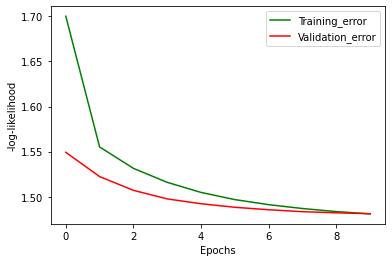

In [15]:
# Training vs Validation error
# Notice the validation error is lower than the training error because I am taking the mean of the log-liklihood of the mini-batches 
# to compute the loss for the training set
plt.plot(training_error, c="green")
plt.plot(validation_error, c="red")
plt.legend(["Training_error", "Validation_error"])
plt.xlabel("Epochs")
plt.ylabel("-log-likelihood")
plt.show()

# Confusion Matrix performance for the Training, Testing, and Validation set

Accuracy 0.9838703703703704


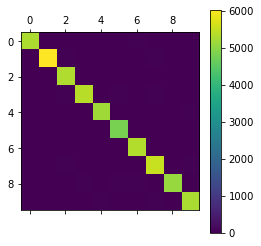

In [16]:
#Training confusion matrix 
y_pred = model(X_train_tensor_4d)
y_p = torch.argmax(y_pred, dim=1)
cnf = confusion_matrix(y_train_tensor, y_p)
plt.matshow(cnf)
plt.colorbar()
print(f"Accuracy {np.sum(np.diag(cnf))/len(X_train_tensor_4d)}")

In [17]:
y_p[0:10]

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])

In [18]:
y_train_tensor[0:10]

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=torch.uint8)

In [19]:
#Validation confusion matrix 
y_pred = model(X_validation_tensor_4d)
y_p = torch.argmax(y_pred, dim=1)
cnf = confusion_matrix(y_validation_tensor, y_p)
print(f"Accuracy {np.sum(np.diag(cnf))/len(X_validation_tensor_4d)}")
cnf

Accuracy 0.9826666666666667


array([[576,   0,   5,   0,   0,   1,   2,   0,   1,   2],
       [  0, 624,   2,   0,   0,   0,   1,   1,   2,   0],
       [  1,   0, 596,   1,   0,   0,   0,   2,   0,   0],
       [  0,   0,   2, 616,   0,   5,   0,   2,   1,   1],
       [  0,   2,   0,   1, 578,   0,   2,   1,   1,  10],
       [  0,   0,   1,   7,   1, 535,   4,   1,   0,   0],
       [  0,   0,   0,   0,   0,   2, 569,   0,   0,   0],
       [  0,   0,   3,   1,   1,   0,   0, 657,   0,   6],
       [  1,   2,   2,   2,   0,   4,   2,   0, 583,   1],
       [  0,   2,   0,   3,   4,   4,   0,   1,   0, 562]], dtype=int64)

In [20]:
#Test confusion matrix 
y_pred = model(X_test_tensor_4d)
y_p = torch.argmax(y_pred, dim=1)
cnf = confusion_matrix(y_test_tensor, y_p)
print(f"Accuracy {np.sum(np.diag(cnf))/len(X_test_tensor_4d)}")
cnf

Accuracy 0.9789


array([[ 964,    0,    4,    1,    1,    1,    4,    1,    3,    1],
       [   0, 1121,    3,    1,    0,    1,    2,    3,    4,    0],
       [   1,    1, 1017,    5,    0,    0,    1,    5,    2,    0],
       [   0,    0,    4,  985,    0,    8,    0,    9,    3,    1],
       [   0,    0,    2,    0,  962,    0,    4,    3,    1,   10],
       [   1,    0,    0,    3,    0,  886,    2,    0,    0,    0],
       [   4,    2,    1,    1,    1,    4,  945,    0,    0,    0],
       [   0,    1,   12,    3,    1,    1,    0, 1005,    0,    5],
       [   3,    0,    8,    8,    4,    6,    3,    4,  935,    3],
       [   1,    4,    0,    6,   10,    9,    1,    9,    0,  969]],
      dtype=int64)

In [21]:
y_p[0:10]

tensor([7, 2, 1, 0, 4, 1, 4, 9, 6, 9])

In [22]:
y_test_tensor[0:10]

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=torch.uint8)

# Perturbing the images using translation, and rotation transformations

In [118]:
class DifferentTransformation(object):
    
    @staticmethod
    def translation(X, y, cols, rows):
        transformation_kind = []
        X_tr = []
        y_tr = []
        original = []
        tx = 1
        ty = 1
        M = np.float32([[1, 0, tx], [0, 1, ty]])
        counter = 0
        #iterate over examples
        while counter < X.shape[0]:
            tx = 1
            for i in range(-5, 5):
                ty = i
                for j in range(-5, 5):
                    M[0, 2] = tx
                    M[1, 2] = ty
                    X_tr.append(cv2.warpAffine(X[counter], M, (cols, rows)))
                    y_tr.append(y[counter])
                    original.append(X[counter])
                    transformation_kind.append(f"translation->tx: {tx} ty: {ty}")
                    ty = j
            counter += 1
        
        return np.asarray(X_tr), np.asarray(y_tr), transformation_kind, original
    
    @staticmethod
    def rotation(X, y, cols, rows):
        transformation_kind = []
        X_tr = []
        y_tr = []
        original = []
        tx = 1
        ty = 1
        counter = 0
        #iterate over examples
        while counter < X.shape[0]:
            for x_angle in range(0, 90, 15):
                M = cv2.getRotationMatrix2D((cols/2, rows/2), x_angle, 1)
                X_tr.append(cv2.warpAffine(X[counter], M, (cols, rows)))
                y_tr.append(y[counter])
                original.append(X[counter])
                transformation_kind.append(f"rotation->angle about x-axis: {x_angle}")
                ty = j
            counter += 1
        
        return np.asarray(X_tr), np.asarray(y_tr), transformation_kind, original

In [119]:
#already standard normalize
X_train_tr = X_train.copy()
y_train_tr =  y_train.copy()
X_train_tr.shape

(54000, 28, 28)

In [128]:
number = 6 # specify the number to change
num_samples = 10 # specify the number of observations
indeces = np.random.permutation(np.where(y_train == number)[0])
indeces = indeces[0:num_samples]
X = X_train_tr[indeces]
y = y_train_tr[indeces]
X.shape

(10, 28, 28)

In [129]:
#X_tr, y_tr, kind, original = DifferentTransformation.translation(X, y, X[0].shape[1], X[0].shape[0])
X_tr, y_tr, kind, original = DifferentTransformation.rotation(X, y, X[0].shape[1], X[0].shape[0])

X_tr_tensor = torch.ones((len(X_tr), 1, 28, 28))
X_tr_tensor[:, 0, :, :] = torch.from_numpy(X_tr)
y_tr_tensor = torch.from_numpy(y_tr)

In [130]:
y_pred = model(X_tr_tensor)
y_p = torch.argmax(y_pred, dim=1)
cnf = confusion_matrix(y_tr_tensor, y_p)
print(f"Accuracy {np.round(np.sum(np.diag(cnf))/len(y_p), 2)}")
cnf

Accuracy 0.55


array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 2,  3,  2,  7,  1, 33,  5,  6,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64)

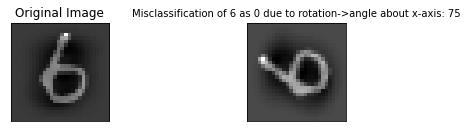

In [131]:
indeces = torch.where(y_p != number)[0]
ind = 10
if ind > len(indeces):
    ind = int(len(indeces)/2)
    
gs = GridSpec(1, 3)
ax_o = plt.subplot(gs[0, 0])
ax = plt.subplot(gs[0, 2])

ax_o.imshow(cv2.normalize(original[indeces[ind]], 0, 255, cv2.NORM_MINMAX), cmap="gray")
ax_o.set_title("Original Image")
ax_o.set_xticks([])
ax_o.set_yticks([])

ax.imshow(X_tr[indeces[ind]], cmap="gray")
ax.set_title(f"Misclassification of {number} as {y_p[indeces[ind]]} due to {kind[indeces[ind]]}", fontsize=10)
ax.set_xticks([])
ax.set_yticks([])
plt.show()